# Assess Distance Metrics

Can we predict which molecules would be most likely to have large errors?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multiprocessing import Pool
from util import has_stereoisomers
from scipy.stats import sem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Results
We computed the error for different molecules in the hold-out sets and distance metrics based on their models

In [7]:
data = dict((x, pd.read_csv(f'{x}.csv').sample(frac=1)) for x in ['molecule', 'atomic-fingerprints'])

## Label if Molecule has Stereoisomers
Using RDKit to count the number of stereoisomers

In [3]:
n_threads = min(32, os.cpu_count())

In [4]:
with Pool(n_threads) as p:
    with_isomers = p.map(has_stereoisomers, tqdm(data['molecule']['smiles']))

100%|██████████| 13217/13217 [07:49<00:00, 28.13it/s]


In [9]:
for v in data.values():
    v['n_conformers'] = with_isomers

## Molecular Fingerprint
Assess outliers for the molecular fingerprint

In [15]:
subset = data['molecule']

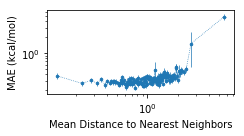

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=4
dist_col = f'train_dist_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', 
            markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

### Atomic-Level Features
We define the distance between molecules as the average distance of each atomic representation

In [17]:
subset = data['atomic-fingerprints']

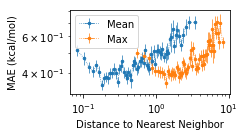

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
for t in ['mean', 'max']:
    dist_col = f'train_dist_{t}_{n}'
    dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                           for s in np.array_split(subset.sort_values(dist_col), 64)[2:]])

    ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=t.capitalize(), marker='o', 
                markersize=2.5, linestyle=':', lw=0.7)
ax.legend()
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.eps'))

*Finding*: Sharper slope for the maximum distance metric.

Determine a "cutoff for the total error?

Paul's thoughts:
- Explore branching as something that would explain a large different differnce in solvation energy with very similar graph structures
- They qauntified branching by means of a vdW volume overlap
- Maybe we need to use the kinds of molecular similarity methods used in chemoinformatics (e.g., using EPC4 fingerprints, or chemoinformatics) 

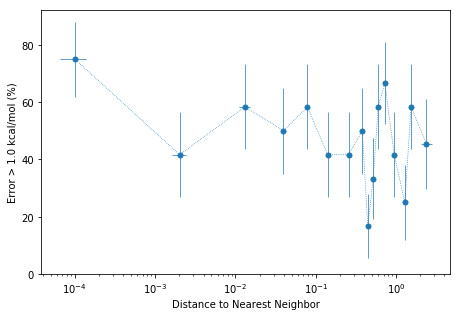

In [36]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))

n=4
error_cutoff = 1 # kcal/mol
dist_col = f'train_dist_mean_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(
    *[(np.mean(s[dist_col]), sem(s[dist_col]), 
       np.mean(s['sol_acn_error'].abs() > error_cutoff) * 100, 
       sem(s['sol_acn_error'].abs() > error_cutoff) * 100) 
      for s in np.array_split(subset.query('n_heavy_atoms>9').sort_values(dist_col), 16)]
)

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem,
            label=f'k={n}', marker='o', 
            markersize=5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylim(0)
ax.set_ylabel(f'Error >{error_cutoff: 0.1f} kcal/mol (%)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.eps'))

*Finding*: We can establish cutoff for "I'm expecting this error to be large"